In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import scipy.stats as sts
plt.style.use('ggplot')    # стиль графиков

Данные взяты с сайта kaggle. https://www.kaggle.com/pritsheta/diabetes-dataset?select=diabetes.csv

In [ ]:
path = '/content/drive/MyDrive/Projects/Diabet/diabetes.csv'
data = pd.read_csv('diabetes.csv')

Данные представляют из себя 7 признаков: беременность, глюкоза, давление, толщина кожи, инсулин, ИМТ, наследственность, возраст и целевую переменную Outcome(есть ли у человека сахарный диабет).
Поставим себе задачу машинного обучения: разобьем датасет на 2 части, и будем прогнозировать значение переменной Outcome.

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
data.shape

(768, 9)

In [ ]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Пропусков нет, работаем дальше

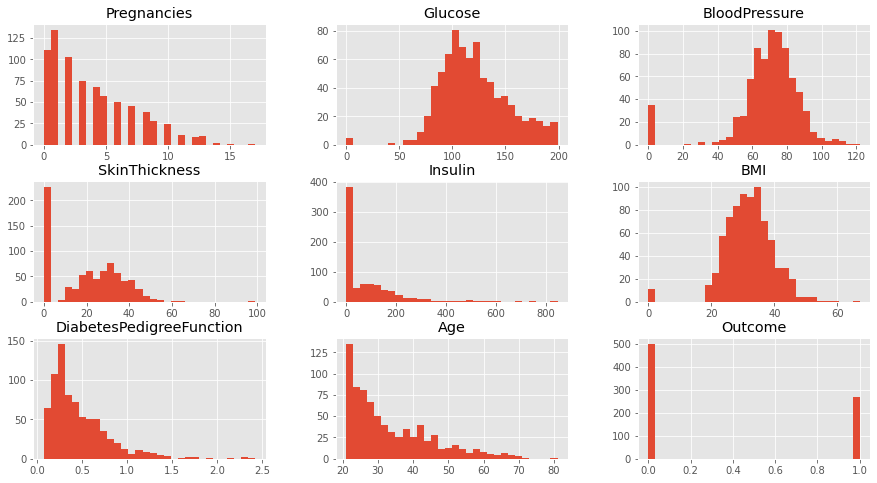

In [ ]:
data[data.columns].hist(bins=30, figsize=(15, 8));

По гистограммам можно сделать несколько полезных выводов:
* 1) Признаки Glucose, BloodPressure, BMI имеют нормальное распределение, что хорошо для нас. 
* 2)В столбцах Glucose, BloodPressure, SkinThickness, Insulin, BMI есть нулевые значения, это скорее всего соответсвует людям, для которых соответсвующий признак не измерялся. С этим нужно будет бороться. 
* 3) От столбцов DiabetsPedigreeFunction, Age, Insulin можно взять логарифм и они могут стать нормально распределенными.

In [ ]:
print('Mean Insulin in data: ' ,data['Insulin'].mean())
print('Std Insulin in data: ', data['Insulin'].std())

Mean Insulin in data:  79.79947916666667
Std Insulin in data:  115.24400235133837


In [ ]:
print('Real mean Insulin', data[data['Insulin'] > 0]['Insulin'].mean())
print('Real std Insulin', data[data['Insulin'] > 0]['Insulin'].std())

Real mean Insulin 155.5482233502538
Real std Insulin 118.77585518724514


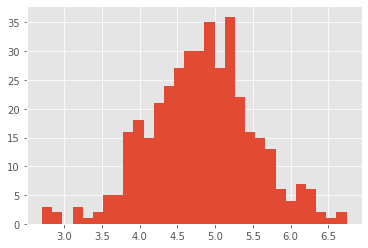

In [ ]:
data[data['Insulin'] > 0]['Insulin'].apply(lambda x: np.log(1 + x)).hist(bins=30);

Видим, что данный признак(без учета нулевых значений) имеет распределение, близкое к нормальному, что сильно облегчает нам жизнь.

У нас слишком мало данных, чтобы выбрасывать строки, в которых значение Insulin = 0, поэтому заполним пропуски иначе: как видно на гистограмме выше, логарифм от Insulin имеет распределение, близкое к нормальному, поэтому сгенерируем новый признак, а затем сгенерируем выборку из такого распределения и заполним сгенерированными значениями некорректные значения.

In [ ]:
data['LogInsulin'] = np.log(1 + data['Insulin'])
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,LogInsulin
0,6,148,72,35,0,33.6,0.627,50,1,0.000000
1,1,85,66,29,0,26.6,0.351,31,0,0.000000
2,8,183,64,0,0,23.3,0.672,32,1,0.000000
3,1,89,66,23,94,28.1,0.167,21,0,4.553877
4,0,137,40,35,168,43.1,2.288,33,1,5.129899


In [ ]:
log_mean = data[data['LogInsulin'] > 0]['LogInsulin'].mean()
log_std = data[data['LogInsulin'] > 0]['LogInsulin'].std()

In [ ]:
norm_rv = sts.norm(loc=log_mean, scale=log_std)

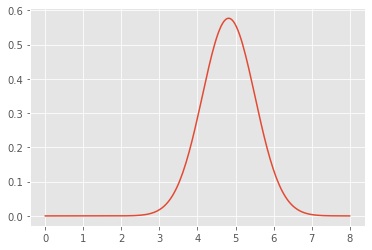

In [ ]:
x = np.linspace(0, 8, 200)
plt.plot(x, norm_rv.pdf(x));

Так выглядит плотность распределения распределения логарифма инсулина

In [ ]:
def f(x):
  if x == 0:
    return norm_rv.rvs(1)[0]
  else:
    return x

In [ ]:
data['LogInsulin'] = data['LogInsulin'].apply(f)

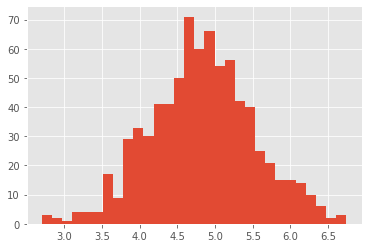

In [ ]:
data['LogInsulin'].hist(bins=30);

Мы добились, чего хотели, теперь у нас есть признак, распределенный нормально, к тому же без незаполненных значений.

Напишем функцию для создания новых признаков

In [ ]:
def create_new_feature(data, feature, new_feature_name, log=True):
  if log:
    data[new_feature_name] = np.log(1 + data[feature])
    mean = data[data[new_feature_name] > 0][new_feature_name].mean()
    std = data[data[new_feature_name] > 0][new_feature_name].std()
    rv = sts.norm(mean, std)
    def g(x):
      if x == 0:
        return rv.rvs(1)[0]
      else:
        return x
    data[new_feature_name] = data[new_feature_name].apply(g)
  else:
    data[new_feature_name] = data[feature]
    mean = data[data[new_feature_name] > 0][new_feature_name].mean()
    std = data[data[new_feature_name] > 0][new_feature_name].std()
    rv = sts.norm(mean, std)
    def g(x):
      if x == 0:
        return rv.rvs(1)[0]
      else:
        return x
    data[new_feature_name] = data[new_feature_name].apply(g)   

In [ ]:
create_new_feature(data, 'SkinThickness', 'LogSkinThickness', log=True)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,LogInsulin,LogSkinThickness
0,6,148,72,35,0,33.6,0.627,50,1,3.896696,3.583519
1,1,85,66,29,0,26.6,0.351,31,0,4.683701,3.401197
2,8,183,64,0,0,23.3,0.672,32,1,5.003377,3.066525
3,1,89,66,23,94,28.1,0.167,21,0,4.553877,3.178054
4,0,137,40,35,168,43.1,2.288,33,1,5.129899,3.583519


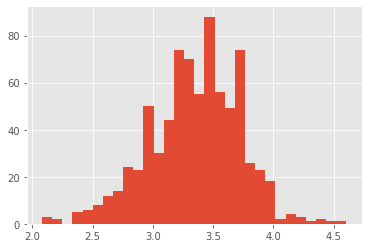

In [ ]:
data['LogSkinThickness'].hist(bins=30);

In [ ]:
create_new_feature(data, 'Glucose', 'LogGlucose', log=False)
create_new_feature(data, 'BloodPressure', 'LogBloodPressure', log=False)
create_new_feature(data, 'BMI', 'LogBMI', log=False)

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,LogInsulin,LogSkinThickness,LogGlucose,LogBloodPressure,LogBMI
0,6,148,72,35,0,33.6,0.627,50,1,3.896696,3.583519,148.0,72.0,33.6
1,1,85,66,29,0,26.6,0.351,31,0,4.683701,3.401197,85.0,66.0,26.6
2,8,183,64,0,0,23.3,0.672,32,1,5.003377,3.066525,183.0,64.0,23.3
3,1,89,66,23,94,28.1,0.167,21,0,4.553877,3.178054,89.0,66.0,28.1
4,0,137,40,35,168,43.1,2.288,33,1,5.129899,3.583519,137.0,40.0,43.1


In [ ]:
data.drop(columns=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'], axis=1, inplace=True)
data.head()

,Pregnancies,DiabetesPedigreeFunction,Age,Outcome,LogInsulin,LogSkinThickness,LogGlucose,LogBloodPressure,LogBMI
0,6,0.627,50,1,3.896696,3.583519,148.0,72.0,33.6
1,1,0.351,31,0,4.683701,3.401197,85.0,66.0,26.6
2,8,0.672,32,1,5.003377,3.066525,183.0,64.0,23.3
3,1,0.167,21,0,4.553877,3.178054,89.0,66.0,28.1
4,0,2.288,33,1,5.129899,3.583519,137.0,40.0,43.1


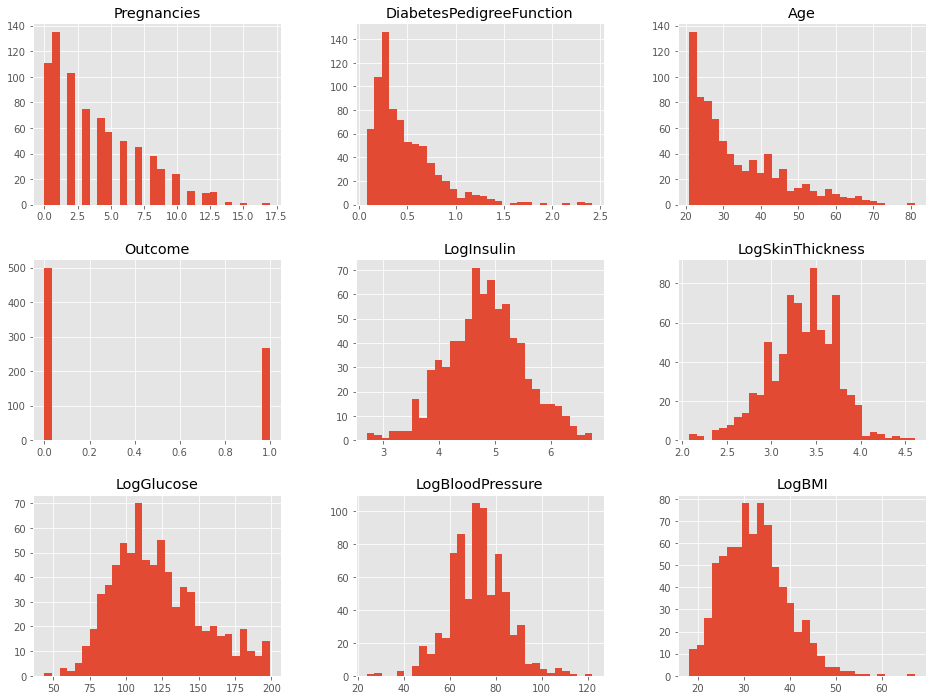

In [ ]:
data[data.columns].hist(bins=30, figsize=(16, 12));

Отлично! Мы поправили почти все, что хотели, осталось лишь прологарифмировать DiabetesPedigreeFunction, т.к. в распределении этого признака слишком большой хвост.

In [ ]:
data['LogDiabetesPedigreeFunction'] = data['DiabetesPedigreeFunction'].apply(lambda x: np.log(1 + x))

In [ ]:
data.drop('DiabetesPedigreeFunction', axis=1, inplace=True)

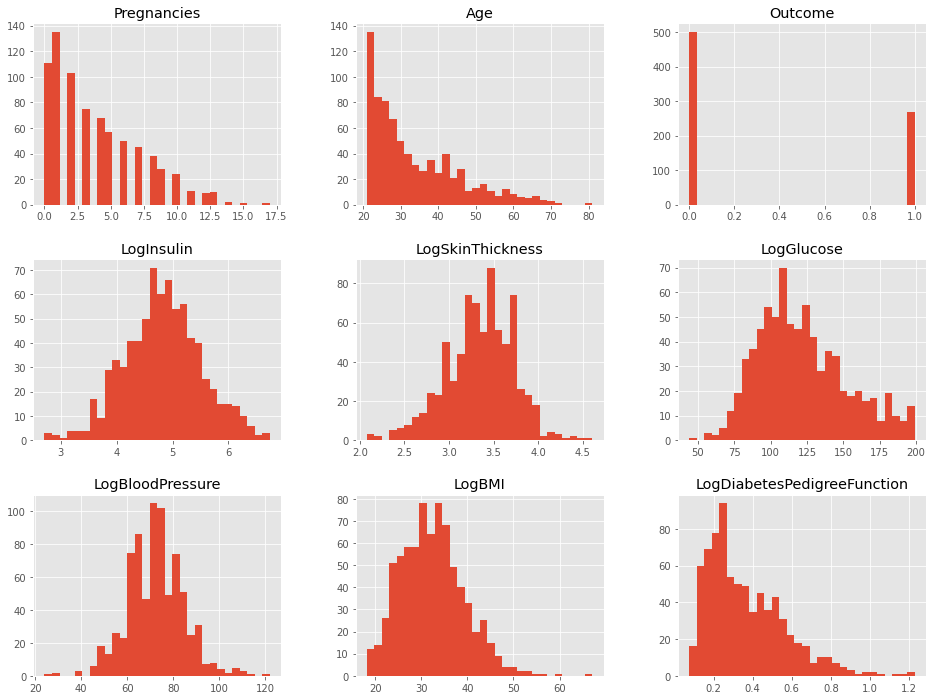

In [ ]:
data[data.columns].hist(bins=30, figsize=(16, 12));

Теперь данные готовы к дальнейшей работе с ними

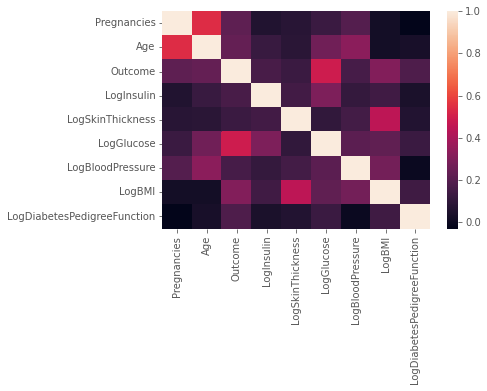

In [ ]:
sns.heatmap(data.corr());

Видим, что Outcome(есть ли диабет) сильнее всего коррелирует с LogGlucose, что довольно логично

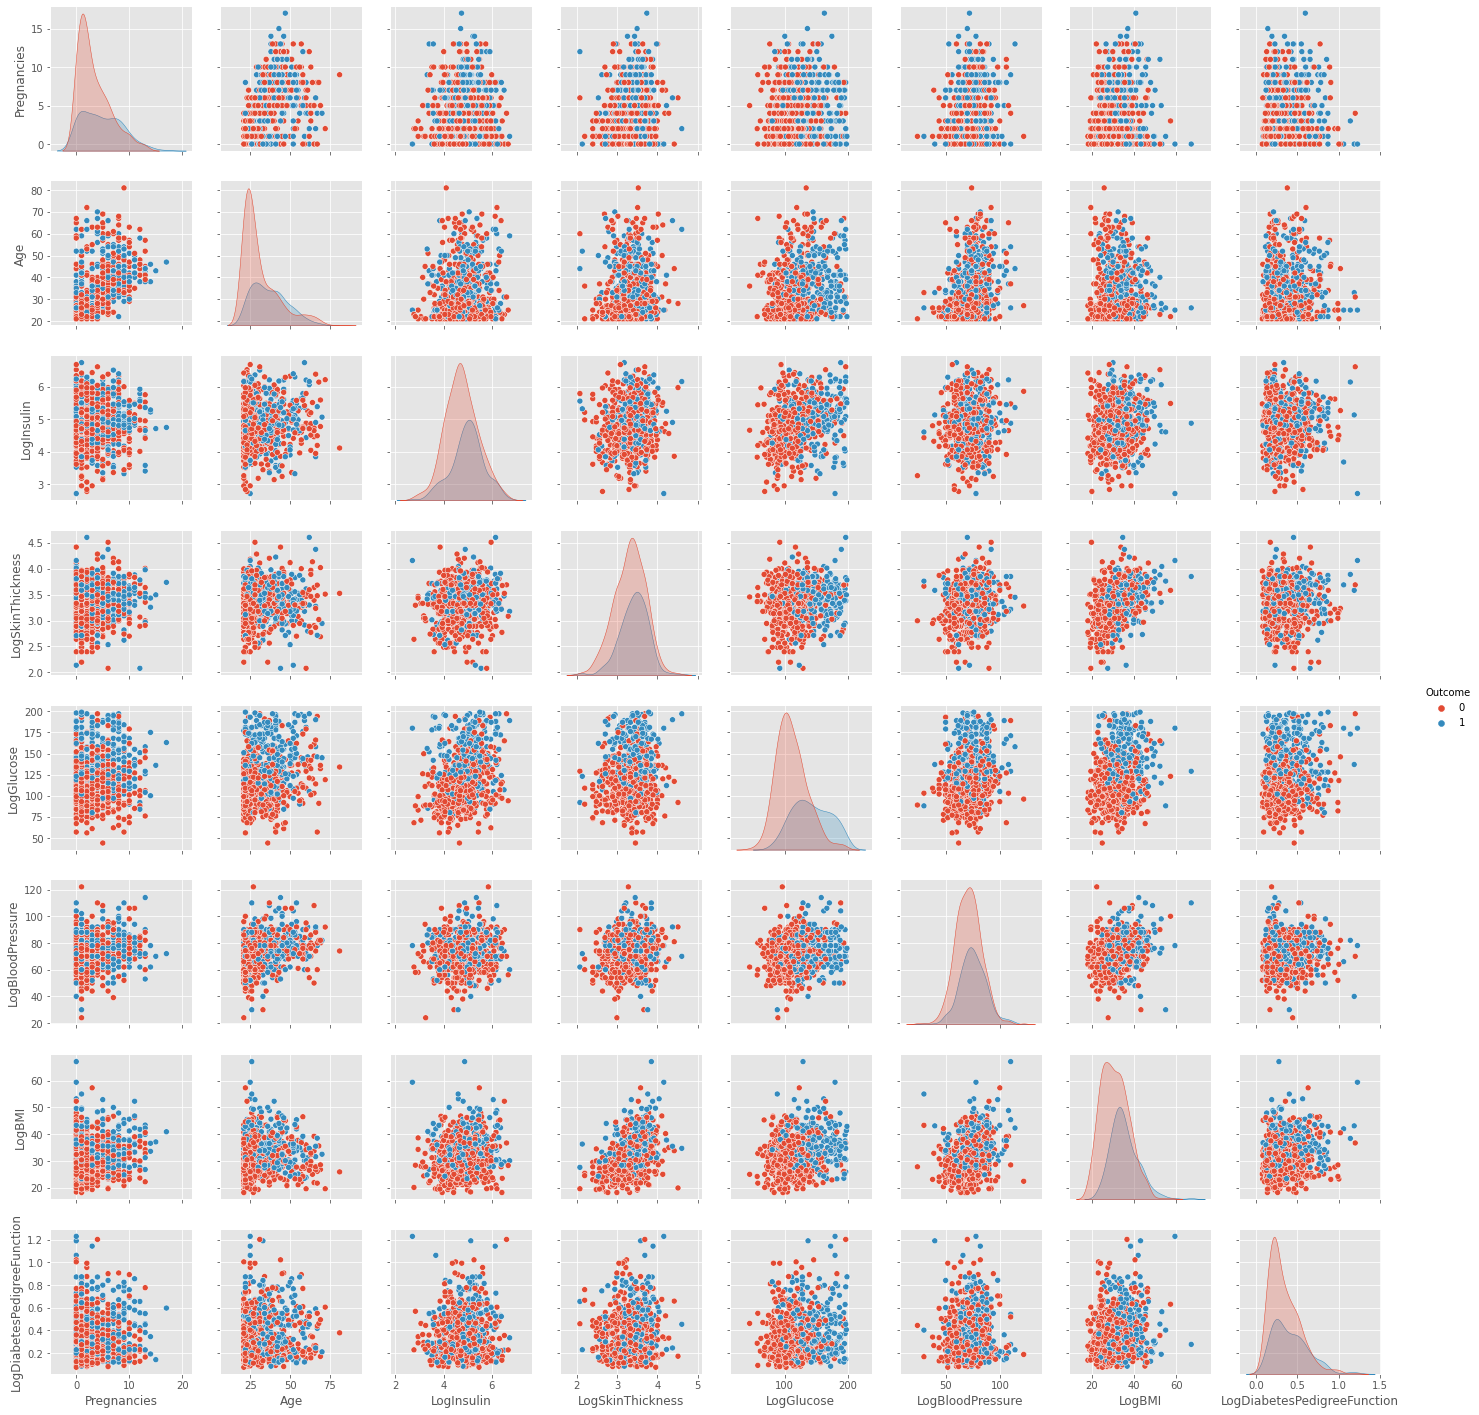

In [ ]:
sns.pairplot(data, hue='Outcome');

Интересно посмотреть на графики, по оси абсцисс у которых отложено значение Glucose. Хорошо видно, что точки со значением Outcome = 1 сдвинуты вправо, то есть эти люди имеют относительно высокое содержание сахара в крови.
То же самое можно сказать и про BMI.

In [ ]:
data_train = data.copy()

Напишем базовую модель.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
target_train = data_train['Outcome']
data_train = data_train[data_train.columns.drop('Outcome')]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train, target_train, train_size=0.8)

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit_transform(X_train)
scaler.transform(X_test);

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression(solver='liblinear')
clf = GridSearchCV(estimator = LogisticRegression(solver='liblinear'),
                   param_grid={'penalty': ['l1', 'l2'],
                               'C': [0.05, 0.1, 0.2, 0.5, 1, 1.5, 2, 5, 10],
                               'max_iter': [70, 100, 150, 200, 300]},
                   cv=4, error_score = 'roc_auc')

In [ ]:
clf.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='roc_auc',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.05, 0.1, 0.2, 0.5, 1, 1.5, 2, 5, 10],
                         'max_iter': [70, 100, 150, 200, 300],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
def results(y, pred):
  print('Accuracy: ', accuracy_score(y, pred))
  print('Roc_Auc: ', roc_auc_score(y, pred))

In [ ]:
results(y_test, y_pred)

Accuracy:  0.7532467532467533
Roc_Auc:  0.7386363636363636


Теперь попробуем решить задачу с помощью решающих деревьев

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model_tree = DecisionTreeClassifier()
clf_tree = GridSearchCV(estimator=model_tree,
                        param_grid = {'max_depth': range(1, 11),
                                      'max_features': ['sqrt', 'log2'],
                                      'min_samples_leaf': range(1, 10)},
                        cv = 3,
                        n_jobs=-1)

In [ ]:
clf_tree.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'ma

In [ ]:
y_pred = clf_tree.predict(X_test)

In [ ]:
results(y_test, y_pred)

Accuracy:  0.6688311688311688
Roc_Auc:  0.6420454545454546


Можно сделать вывод: решающее дерево с задачей справилось хуже.

Теперь попробуем случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model_forest = RandomForestClassifier(n_estimators=350)
clf_forest = GridSearchCV(estimator=model_forest,
                          param_grid={'max_features': ['sqrt', 'log2']},
                          n_jobs=-1)

In [ ]:
clf_forest.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=350, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
y_pred = clf_forest.predict(X_test)

In [ ]:
results(y_test, y_pred)

Accuracy:  0.7467532467532467
Roc_Auc:  0.7329545454545454


Вывод: случайный лес хорошо справился с задачей.

Теперь попробуем градиентный бустинг.

In [ ]:
pip install catboost

In [ ]:
import catboost
from catboost import CatBoostClassifier

In [ ]:
model_cat = CatBoostClassifier(cat_features=None)

In [ ]:
grid_cat = GridSearchCV(estimator=model_cat,
                        param_grid={'iterations': [300, 350],
                                    'depth': [1,2,3,4],
                                    'eta': [1, 0.5],
                                    'subsample': [0.6, 0.8, 1]
                                    },
                        n_jobs=-1)

In [ ]:
grid_cat.fit(X_train, y_train)

0:	learn: 0.5909386	total: 48.6ms	remaining: 16.9s
1:	learn: 0.5479526	total: 50.1ms	remaining: 8.71s
2:	learn: 0.5188221	total: 50.8ms	remaining: 5.88s
3:	learn: 0.4989866	total: 51.6ms	remaining: 4.46s
4:	learn: 0.4837542	total: 52.3ms	remaining: 3.61s
5:	learn: 0.4722968	total: 53ms	remaining: 3.04s
6:	learn: 0.4659891	total: 53.6ms	remaining: 2.63s
7:	learn: 0.4628416	total: 54.4ms	remaining: 2.33s
8:	learn: 0.4556790	total: 55ms	remaining: 2.08s
9:	learn: 0.4525265	total: 55.7ms	remaining: 1.89s
10:	learn: 0.4471306	total: 56.4ms	remaining: 1.74s
11:	learn: 0.4452987	total: 57ms	remaining: 1.61s
12:	learn: 0.4388621	total: 57.7ms	remaining: 1.5s
13:	learn: 0.4379565	total: 58.3ms	remaining: 1.4s
14:	learn: 0.4335117	total: 58.9ms	remaining: 1.32s
15:	learn: 0.4308271	total: 59.6ms	remaining: 1.24s
16:	learn: 0.4291972	total: 60.3ms	remaining: 1.18s
17:	learn: 0.4267231	total: 61ms	remaining: 1.12s
18:	learn: 0.4259716	total: 61.6ms	remaining: 1.07s
19:	learn: 0.4236951	total: 62.3

GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7ff01fe45f90>,
             iid='deprecated', n_jobs=-1,
             param_grid={'depth': [1, 2, 3, 4], 'eta': [1, 0.5],
                         'iterations': [300, 350], 'subsample': [0.6, 0.8, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
y_pred = grid_cat.predict(X_test)

In [ ]:
results(y_test, y_pred)

Accuracy:  0.7272727272727273
Roc_Auc:  0.7140151515151515


Бустинг тоже неплохо справился с задачей.

Подытожим, что мы сделали.
* 1) Поставили задачу машинного обучения
* 2) Посмотрели на данные и поняли, что в них есть существенные проблемы
* 3) Устранили проблемы в данных и подготовили их для использования алгоритмами машинного обучения
* 4) Обучили несколько моделей и сравнили их качетсво. Логистическая регрессия справилась с задачей лучше всего.